In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('data/anna.txt','r') as f:
    text = f.read().lower()

In [3]:
tokens = list(set(text))
char2int = {ch:ind for ind, ch in enumerate(tokens)}
text2int = np.array([char2int[ch] for ch in text])

In [4]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [5]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
    '''    
    # Get the number of batches
    full_batch_size = batch_size * seq_length
    n_batches = len(arr) // full_batch_size
    
    # Remove unused elements from the end of arr
    use_len = n_batches * full_batch_size
    arr = arr[:use_len]
    # Reshape into batch_size rows
    arr = arr.reshape(batch_size,-1)
    
    ## Iterate over the batches using a window of size seq_length
    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:(n+seq_length)] # Training data
        y = np.roll(x,-1) # Target = circular left shift of x by 1
        yield x, y

In [6]:
class CharLSTM(nn.Module):
    def __init__(self, tokens, n_hidden=16, n_layers=1, drop_prob=0.5):
        super(CharLSTM, self).__init__()
        self.tokens = tokens
        self.char2int = {ch:ind for ind, ch in enumerate(self.tokens)}
        self.int2char = {ind:ch for ind, ch in enumerate(self.tokens)}
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        
        # LSTM
        self.lstm = nn.LSTM(len(self.tokens), self.n_hidden, self.n_layers,
                            dropout=self.drop_prob, batch_first=True)
        self.dropout = nn.Dropout(self.drop_prob)
        self.fc = nn.Linear(self.n_hidden, len(self.tokens))
                
    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)
        if self.n_layers > 1:
            x = x.contiguous()
        x = x.view(-1, self.n_hidden)
        x = self.fc(x)
        return x, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Check if GPU is available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

In [7]:
def train(model, xtrain, n_epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1):
    ''' 
    Input arguments:
    ---------------
    model -- model to train
    data -- training data
    clip -- threshold to avoid exploding gradient problem
    val_frac -- fraction of data will be used for validation
    '''
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.train() # Keep model in training mode
    model = model.to(device) # Send model to GPU, if available
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Split train and validation data
    val_idx = int(len(xtrain)*(1-val_frac))
    xtrain, xvalid = xtrain[:val_idx], xtrain[val_idx:]

    train_loss_epochs = []
    valid_loss_epochs = []
    min_valid_loss = np.inf
    n_tokens = len(model.tokens)
    for iepoch in range(n_epochs):
        # initialize hidden state
        h = model.init_hidden(batch_size)
        train_loss_batch = []
        for ibatch, (x, y) in enumerate(get_batches(xtrain, batch_size, seq_length)):
            if (iepoch+1)%1 == 0:
                progress = (ibatch+1) / (len(xtrain) // (batch_size * seq_length)) * 100
                sys.stdout.flush()
                sys.stdout.write('\rEpoch {}/{} ... {:0.2f}% ... '
                                 .format(iepoch+1, n_epochs, progress))
            
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_tokens)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            inputs, targets = inputs.to(device), targets.long().to(device)

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            model.zero_grad()
            
            # get the output from the model
            output, h = model(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length))
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            
            train_loss_batch.append(loss.item())
        train_loss_epochs.append( np.mean(train_loss_batch) )
        
        # Get validation loss
        val_h = model.init_hidden(batch_size)
        valid_loss_batch = []
        model.eval()
        for x, y in get_batches(xvalid, batch_size, seq_length):
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_tokens)
            x, y = torch.from_numpy(x), torch.from_numpy(y)

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = tuple([each.data for each in val_h])

            inputs, targets = x, y
            inputs, targets = inputs.to(device), targets.long().to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, targets.view(batch_size*seq_length))

            valid_loss_batch.append(val_loss.item())

        model.train() # reset to train mode after iterationg through validation data
        
        # Accumulate training validation loss over the epochs
        valid_loss_epochs.append(np.mean(valid_loss_batch))
        # Update min_valid_loss and save model
        if valid_loss_epochs[iepoch] < min_valid_loss:
            min_valid_loss = valid_loss_epochs[iepoch]
            model_name = 'next-char-predict-lstm.net'
            checkpoint = {'n_hidden': model.n_hidden,
                          'n_layers': model.n_layers,
                          'state_dict': model.state_dict(),
                          'tokens': model.tokens}
            with open(model_name, 'wb') as f:
                torch.save(checkpoint, f)
        # Display losses
        if (iepoch+1)%1 == 0:
            print("Training loss: {:.4f}...".format(train_loss_epochs[iepoch]),
                  "Validation loss: {:.4f}".format(valid_loss_epochs[iepoch]))
    return train_loss_epochs, valid_loss_epochs

In [8]:
n_hidden = 512
n_layers = 2

model = CharLSTM(tokens, n_hidden, n_layers)
print(model)

CharLSTM(
  (lstm): LSTM(57, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=57, bias=True)
)


In [9]:
batch_size = 128
seq_length = 100
val_frac = 0.1
n_epochs =  20

# train the model
train_loss, valid_loss = train(model, text2int, n_epochs=n_epochs, batch_size=batch_size,
                               seq_length=seq_length, lr=0.001, val_frac=val_frac)

Epoch 1/20 ... 100.00% ... Training loss: 3.0241... Validation loss: 2.5851
Epoch 2/20 ... 100.00% ... Training loss: 2.3613... Validation loss: 2.1340
Epoch 3/20 ... 100.00% ... Training loss: 2.0498... Validation loss: 1.8934
Epoch 4/20 ... 100.00% ... Training loss: 1.8621... Validation loss: 1.7420
Epoch 5/20 ... 100.00% ... Training loss: 1.7370... Validation loss: 1.6397
Epoch 6/20 ... 100.00% ... Training loss: 1.6509... Validation loss: 1.5681
Epoch 7/20 ... 100.00% ... Training loss: 1.5869... Validation loss: 1.5163
Epoch 8/20 ... 100.00% ... Training loss: 1.5358... Validation loss: 1.4769
Epoch 9/20 ... 100.00% ... Training loss: 1.4960... Validation loss: 1.4481
Epoch 10/20 ... 100.00% ... Training loss: 1.4622... Validation loss: 1.4205
Epoch 11/20 ... 100.00% ... Training loss: 1.4341... Validation loss: 1.4008
Epoch 12/20 ... 100.00% ... Training loss: 1.4086... Validation loss: 1.3851
Epoch 13/20 ... 100.00% ... Training loss: 1.3869... Validation loss: 1.3681
Epoch 14

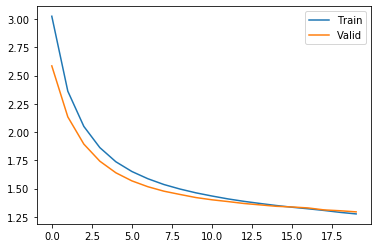

In [10]:
plt.plot(train_loss, label='Train')
plt.plot(valid_loss, label='Valid')
plt.legend()
plt.show()

In [9]:
def predict(model, char, hidden=None, top_k=None):
    ''' Given a character, predict the next character.
        Returns the predicted character and the hidden state.
    '''        
    # tensor inputs
    x = np.array([[model.char2int[char]]])
    x = one_hot_encode(x, len(model.tokens))
    inputs = torch.from_numpy(x)

    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inputs = inputs.to(device)

    # Detach hidden state from history
    hidden = tuple([each.data for each in hidden])
    # get the output of the model
    outputs, hidden = model(inputs, hidden)

    # Get character probabilities
    p = F.softmax(outputs, dim=1).data
    p = p.to('cpu') # move to cpu

    # Top characters
    if top_k is None:
        top_ch = np.arange(len(model.tokens))
    else:
        p, top_ch = p.topk(top_k)
        top_ch = top_ch.numpy().squeeze()

    # select the likely next character with some element of randomness
    p = p.numpy().squeeze()
    token_int = np.random.choice(top_ch, p=p/p.sum())
    char = model.int2char[token_int]
    # return the encoded value of the predicted char and the hidden state
    return char, hidden


def sample(model, size, prime='The', top_k=None):
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    hidden = model.init_hidden(1)
    for ch in prime:
        char, hidden = predict(model, ch, hidden, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, hidden = predict(model, chars[-1], hidden, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [10]:
with open('next-char-predict-lstm.net', 'rb') as f:
    checkpoint = torch.load(f)
    
model = CharLSTM(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [12]:
prime = 'Anna'.lower()
print(sample(model, 2000, prime=prime, top_k=5))

anna, however thought it is
starting from a smile, but in the portrait of them, and the peasants our ofting the
starts of his brother's action to always seem that it was so much at horrow on them, and then the passions they
were a service. if they will be different., it's such a studie words, to
go all to be a corpanion at other stead that, i should have
something thinking. you're not
tonnur about in the simpless of making any man into his
son, but his wife then there's no offort, and to stepan
arkadyevitch where said: to be that more well as
a stupid of a pleasuse, where i see. indeed you had not to
be the bedune in those persence.... and i see than it was
nine a times and an to the men of my frunh, but i don't call a long, as
they, i sand in serious, as it's natural, and they dressed in
the peasants was an expected of the calles."

"and there was stiva!" he thought, "what is!" she thought,
sitcing to him to the country, silkny with the same
princess that wear hands of the memory of t